In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os 

from neuropacks import ECOG
from sklearn.decomposition import NMF
from uoineuro.tuning_utils import calculate_best_frequencies_ecog
from uoineuro.dimensionality_reduction_utils import *

%matplotlib inline

In [2]:
nmf_bcv_results = h5py.File('/Users/psachdeva/fits/uoineuro/dimensionality_reduction/nmf_ecog.h5', 'r')

In [3]:
n_hyperparameters = len(nmf_bcv_results)
n_ranks = len(nmf_bcv_results['l1_ratio0.01_alpha0.001/errors'])
errors = np.zeros((n_hyperparameters, n_ranks))
groups = []

for idx, hyperparameter in enumerate(list(nmf_bcv_results)):
    groups.append(nmf_bcv_results[hyperparameter])
    errors[idx] = nmf_bcv_results[hyperparameter]['errors'][:]

In [4]:
min_group = groups[np.argmin(np.min(errors, axis=1))]
min_rank = np.argmin(min_group['errors']) + 1

In [5]:
print(min_group)
print(min_rank)

<HDF5 group "/l1_ratio0._alpha1.0" (1 members)>
29


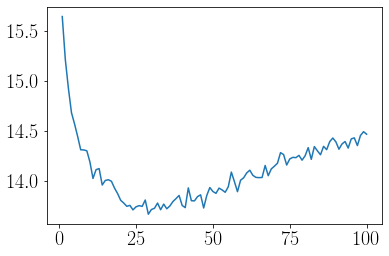

In [6]:
plt.plot(np.arange(1, 101), np.log(min_group['errors']))

In [7]:
data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')
ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path
)
dead_electrodes = [0, 19, 21]

In [8]:
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG'
)

In [9]:
# kill the dead indices
Y[:, dead_electrodes] = 0
Y = Y + np.abs(np.min(Y, axis=0, keepdims=True))

In [10]:
nmf = NMF(
    n_components=29,
    l1_ratio=0.0,
    alpha=1.0,
    beta_loss='frobenius',
    solver='cd',
    max_iter=1000,
    init='random')

In [11]:
nmf.fit(Y)

NMF(alpha=1.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
    max_iter=1000, n_components=29, random_state=None, shuffle=False,
    solver='cd', tol=0.0001, verbose=0)

In [12]:
tuning_results = h5py.File('/Users/psachdeva/fits/uoineuro/tuning/ecog/ecog_tuning.h5', 'r')

In [13]:
tuning_coefs = np.median(tuning_results['uoi_lasso_bic/tuning_coefs'], axis=0)
pref_frequencies = calculate_best_frequencies_ecog(tuning_coefs, ecog, return_grid=True, omit_idxs=dead_electrodes)

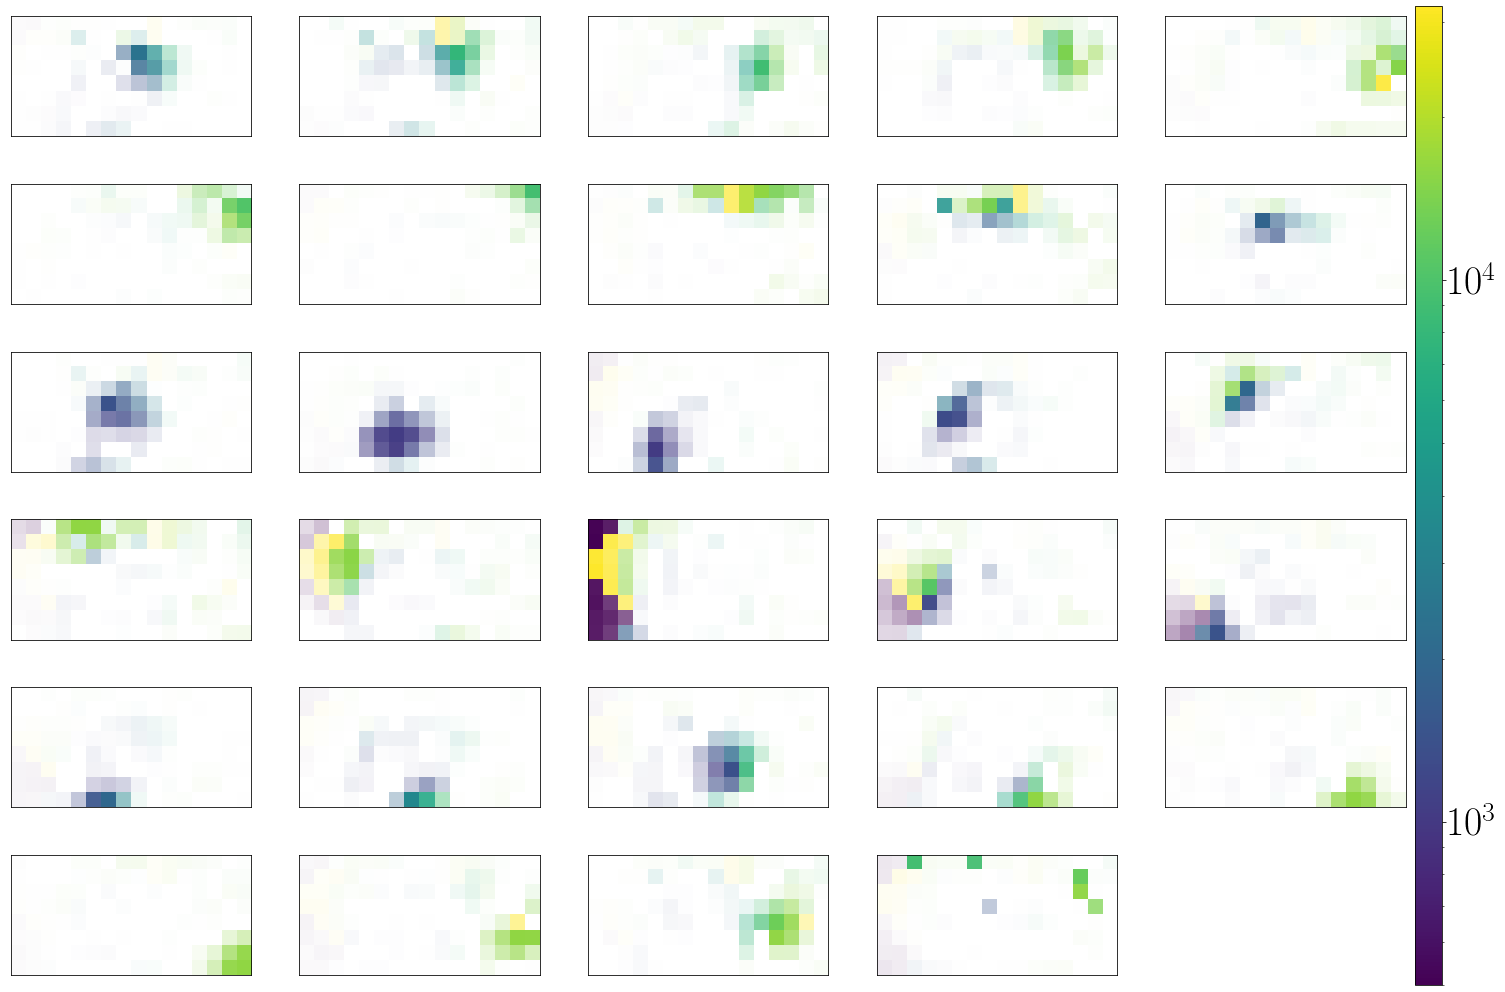

In [46]:
fig, axes = plot_ecog_bases(nmf.components_, ecog,
                            pref_freqs=pref_frequencies,
                            cmap='viridis',
                            n_cols=5)
axes[-1, -1].axis('off')

# create colorbar
fig_invert = fig.transFigure.inverted()
ax_bottom_right_x, ax_bottom_right_y = \
    fig_invert.transform(axes[-1, -1].transAxes.transform([1.0, 0.]))
ax_top_right_x, ax_top_right_y = \
    fig_invert.transform(axes[0, -1].transAxes.transform([1.0, 1.0]))
cax = fig.add_axes([ax_bottom_right_x + 0.005,
                    ax_bottom_right_y,
                    0.015,
                    ax_top_right_y - ax_bottom_right_y])
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.LogNorm(vmin=ecog.freq_set[0],
                                                                              vmax=ecog.freq_set[-1]),
                                                                              cmap='viridis'),
                  cax=cax)
cb.ax.tick_params(labelsize=40)

plt.show()


In [48]:
ax_bottom_right_y

0.12499999999999989